In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

NotImplementedError: ignored

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

NotImplementedError: ignored

In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
import json

def is_coco_format(file_path):
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)

        # Check if the main keys are present
        if not all(key in data for key in ["images", "annotations", "categories"]):
            return False

        # Check if 'images' has the required keys
        for image in data["images"]:
            if not all(key in image for key in ["height", "width", "id", "file_name"]):
                return False

        # Check if 'annotations' has the required keys
        for annotation in data["annotations"]:
            if not all(key in annotation for key in ["iscrowd", "image_id", "bbox", "category_id", "id", "area"]):
                return False

        # Check if 'categories' has the required keys
        for category in data["categories"]:
            if not all(key in category for key in ["id", "name"]):
                return False

        return True
    except Exception as e:
        print(f"An error occurred: {e}")
        return False

In [ ]:
file_path = '/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json'
result = is_coco_format(file_path)
print(f"Is COCO Format: {result}")

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json", "/content/drive/MyDrive/CarDD_release/CarDD_COCO/train2017")

In [ ]:
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json", "/content/drive/MyDrive/CarDD_release/CarDD_COCO/val2017")

In [ ]:
from detectron2.data import DatasetCatalog

def is_dataset_registered(name):
    return name in DatasetCatalog.list()

dataset_name = "my_dataset_train"
if is_dataset_registered(dataset_name):
    print(f"The dataset '{dataset_name}' is registered.")
else:
    print(f"The dataset '{dataset_name}' is not registered.")

The dataset 'my_dataset_train' is registered.


[12/16 11:45:09 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json


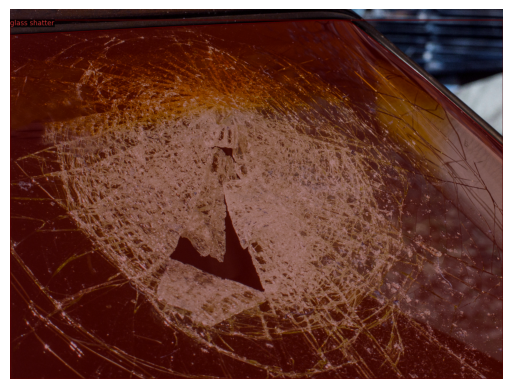

In [ ]:
import random
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.utils.visualizer import Visualizer
import cv2
import matplotlib.pyplot as plt

# Load the dataset and retrieve metadata
dataset_dicts = DatasetCatalog.get(dataset_name)
dataset_metadata = MetadataCatalog.get(dataset_name)

# Pick a random sample from the dataset
sample = random.choice(dataset_dicts)

# Read the image
img = cv2.imread(sample["file_name"])

# Create a Visualizer object
visualizer = Visualizer(img[:, :, ::-1], metadata=dataset_metadata)

# Visualize the annotations
vis_output = visualizer.draw_dataset_dict(sample)

# Display the image using Matplotlib
plt.imshow(vis_output.get_image()[:, :, ::-1])
plt.axis("off")
plt.show()

In [ ]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
from detectron2.data import DatasetMapper, build_detection_train_loader
from detectron2.data import transforms as T
import copy
import torch
from detectron2.data import detection_utils as utils
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [ ]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
        T.RandomRotation(angle=[90, 180, 270]),  # Simple rotation
        T.RandomContrast(0.8, 1.2),             # Random contrast
        T.RandomBrightness(0.8, 1.2),           # Random brightness
    ]

    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


In [ ]:
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer
import os

In [ ]:
def get_category_ids(dataset_dict_list):
    category_ids = set()
    for dataset_dict in dataset_dict_list:
        for anno in dataset_dict['annotations']:
            category_ids.add(anno['category_id'])
    return category_ids

dataset_dict_list = DatasetCatalog.get("my_dataset_train")
actual_category_ids = get_category_ids(dataset_dict_list)

print("Actual Category IDs in the dataset:", actual_category_ids)

# Update your class_labels based on the actual category IDs
class_labels = sorted(list(actual_category_ids))
print("Updated Class Labels:", class_labels)

[12/16 11:45:11 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json
Actual Category IDs in the dataset: {0, 1, 2, 3, 4, 5}
Updated Class Labels: [0, 1, 2, 3, 4, 5]


In [ ]:
from torch.utils.data.sampler import Sampler
import numpy as np

class BalancedClassSampler(Sampler):
    """
    Sampler that oversamples minority classes in the dataset.
    """
    def __init__(self, dataset_dict_list, class_labels):
        self.dataset_dict_list = dataset_dict_list
        self.indices = list(range(len(self.dataset_dict_list)))
        self.num_samples = len(self.dataset_dict_list)
        self.class_counts = self._count_classes(self.dataset_dict_list, class_labels)
        self.weights = self._compute_weights()

    def _count_classes(self, dataset_dict_list, class_labels):
        count_dict = {label: 0 for label in class_labels}
        for dataset_dict in dataset_dict_list:
            for anno in dataset_dict['annotations']:
                count_dict[anno['category_id']] += 1
        return count_dict

    def _compute_weights(self):
        # Find the maximum class count to inverse the frequency
        max_count = max(self.class_counts.values())
        weights = []
        for dataset_dict in self.dataset_dict_list:
            # Find the minimum class count in this image
            min_class_count = min(self.class_counts[anno['category_id']] for anno in dataset_dict['annotations'])
            # The weight is higher if the image contains a minority class
            weights.append(max_count / min_class_count)
        return torch.tensor(weights, dtype=torch.float)

    def __iter__(self):
        # No need to iterate through self.indices as torch.multinomial will return indices directly
        return iter(torch.multinomial(self.weights, self.num_samples, replacement=True).tolist())

    def __len__(self):
        return self.num_samples

In [ ]:
def custom_train_loader(cfg, dataset_name, class_labels):
    # Fetch the dataset dictionary list from Detectron2's dataset registry
    dataset_dicts = DatasetCatalog.get(dataset_name)

    # Create a sampler instance
    sampler = BalancedClassSampler(dataset_dicts, class_labels)

    # Return the Detectron2 train loader with our custom sampler
    return build_detection_train_loader(cfg, mapper=custom_mapper, sampler=sampler)

In [ ]:
class_labels = [0, 1, 2, 3, 4, 5]

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        # Use the name of your training dataset
        return custom_train_loader(cfg, "my_dataset_train", class_labels)

In [ ]:
import matplotlib.pyplot as plt

def count_class_instances(dataset_dict_list, class_labels):
    count_dict = {label: 0 for label in class_labels}
    for dataset_dict in dataset_dict_list:
        for anno in dataset_dict['annotations']:
            count_dict[anno['category_id']] += 1
    return count_dict

def simulate_balanced_sampling(dataset_dict_list, class_labels, num_batches, batch_size):
    sampler = BalancedClassSampler(dataset_dict_list, class_labels)
    # Assuming you want to simulate the same number of samples as your training set
    num_samples = num_batches * batch_size
    sampled_indices = [next(iter(sampler)) for _ in range(num_samples)]
    sampled_count_dict = {label: 0 for label in class_labels}
    for idx in sampled_indices:
        for anno in dataset_dict_list[idx]['annotations']:
            sampled_count_dict[anno['category_id']] += 1
    return sampled_count_dict

def plot_class_distribution(counts, title):
    labels = list(counts.keys())
    values = list(counts.values())

    plt.bar(labels, values)
    plt.xlabel('Class ID')
    plt.ylabel('Number of Instances')
    plt.title(title)
    plt.show()

In [ ]:
dataset_dict_list = DatasetCatalog.get("my_dataset_train")
original_counts = count_class_instances(dataset_dict_list, class_labels)
sampled_counts = simulate_balanced_sampling(dataset_dict_list, class_labels, len(dataset_dict_list),4)

[12/16 11:45:13 d2.data.datasets.coco]: Loaded 2816 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_train2017.json


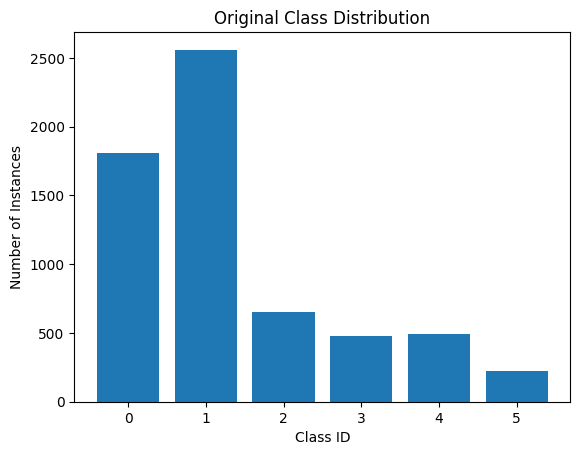

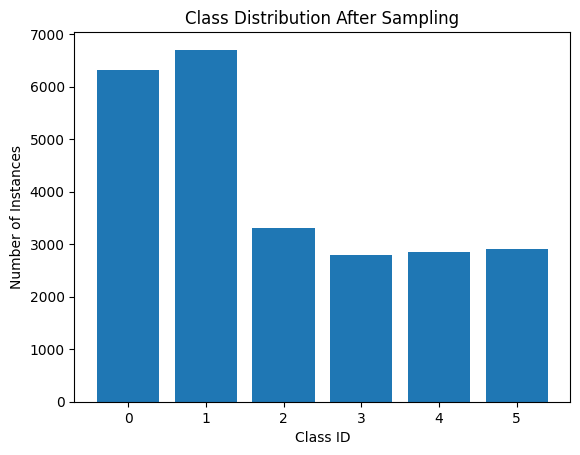

In [ ]:
plot_class_distribution(original_counts, 'Original Class Distribution')
plot_class_distribution(sampled_counts, 'Class Distribution After Sampling')

In [ ]:
# Define hyperparameters
batch_size = 4  # Example batch size

# Configure the model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = batch_size
cfg.SOLVER.BASE_LR = 0.00025  # Starting learning rate
cfg.TEST.EVAL_PERIOD = 1000
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = (2000, 3000)  # Points to decrease the learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6
cfg.SOLVER.CHECKPOINT_PERIOD = 500
# Learning rate scheduler configuration
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.GAMMA = 0.1  # Learning rate reduction factor
cfg.SOLVER.LR_SCHEDULER_NAME = "WarmupCosineLR"
cfg.SOLVER.WEIGHT_DECAY = 0.001  # Regularization - weight decay

# Set up output directory
output_dir = "/content/drive/MyDrive/output_cascade"
os.makedirs(output_dir, exist_ok=True)
cfg.OUTPUT_DIR = output_dir

# Initialize the trainer and start training
trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[12/16 15:16:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

KeyboardInterrupt: ignored

In [ ]:
import json
import matplotlib.pyplot as plt

# Path to your JSON file
json_file_path = '/content/drive/MyDrive/output_cascade/metrics.json'

# Read data from JSON file
json_data = []
with open(json_file_path, 'r') as file:
    for line in file:
        json_data.append(json.loads(line))

# Extracting data
iterations = [d["iteration"] for d in json_data]
total_losses = [d["total_loss"] for d in json_data]
loss_cls = [d["loss_cls_stage0"] for d in json_data]
loss_box_reg = [d["loss_box_reg_stage0"] for d in json_data]
loss_mask = [d["loss_mask"] for d in json_data]
accuracies = [d["mask_rcnn/accuracy"] for d in json_data]
false_negatives = [d["mask_rcnn/false_negative"] for d in json_data]
false_positives = [d["mask_rcnn/false_positive"] for d in json_data]

# Plotting
plt.figure(figsize=(15, 10))

# Total Loss
plt.subplot(3, 2, 1)
plt.plot(iterations, total_losses, marker='o')
plt.title('Total Loss over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Total Loss')

# Loss - Classification
plt.subplot(3, 2, 2)
plt.plot(iterations, loss_cls, marker='o', color='r')
plt.title('Loss - Classification Stage 0 over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss - Classification')

# Loss - Box Regression
plt.subplot(3, 2, 3)
plt.plot(iterations, loss_box_reg, marker='o', color='g')
plt.title('Loss - Box Regression Stage 0 over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss - Box Regression')

# Loss - Mask
plt.subplot(3, 2, 4)
plt.plot(iterations, loss_mask, marker='o', color='b')
plt.title('Loss - Mask over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Loss - Mask')

# Accuracy
plt.subplot(3, 2, 5)
plt.plot(iterations, accuracies, marker='o', color='c')
plt.title('Mask R-CNN Accuracy over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')

# False Positives and False Negatives
plt.subplot(3, 2, 6)
plt.plot(iterations, false_negatives, marker='o', color='m', label='False Negatives')
plt.plot(iterations, false_positives, marker='o', color='y', label='False Positives')
plt.title('False Positives and Negatives over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Rate')
plt.legend()

plt.tight_layout()
plt.show()



KeyError: ignored

In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

In [1]:
# Initialize the configuration
cfg = get_cfg()

# Load the base configuration from model zoo
cfg.merge_from_file(model_zoo.get_config_file("Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml"))

# Set the path to the trained model weights
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/output_cascade/model_0003499.pth"

# Set the number of classes
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6  # Update this based on your dataset

# Set the testing threshold for this model
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5

# Specify the test dataset
cfg.DATASETS.TEST = ("my_dataset_val",)

NameError: ignored

In [ ]:
from detectron2.engine import DefaultPredictor
predictor = DefaultPredictor(cfg)

[12/16 15:24:05 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/output_cascade/model_0002499.pth ...


[12/16 15:24:09 d2.data.datasets.coco]: Loading /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json takes 1.04 seconds.
[12/16 15:24:09 d2.data.datasets.coco]: Loaded 810 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json


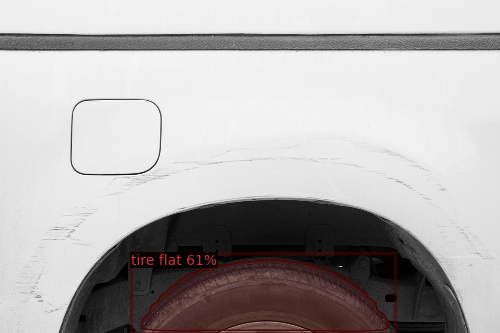

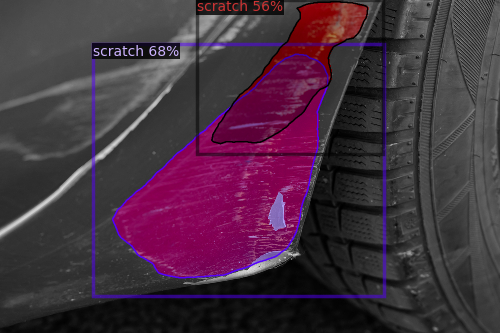

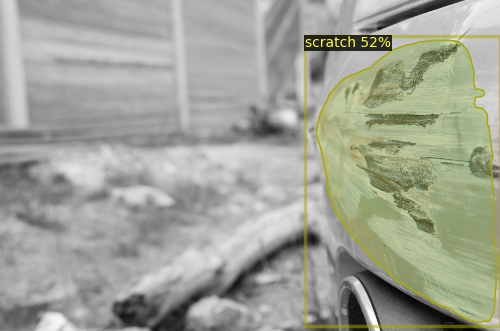

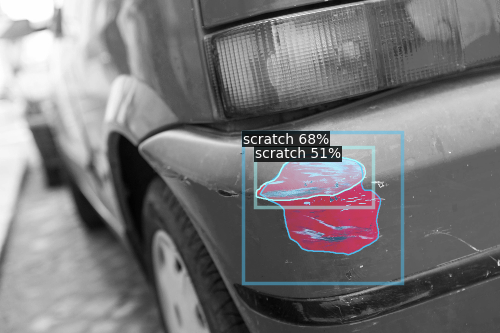

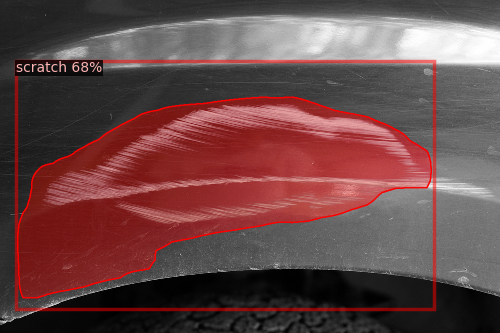

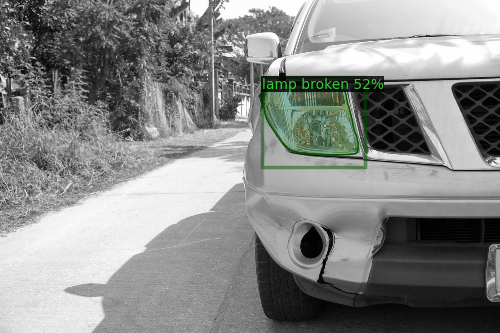

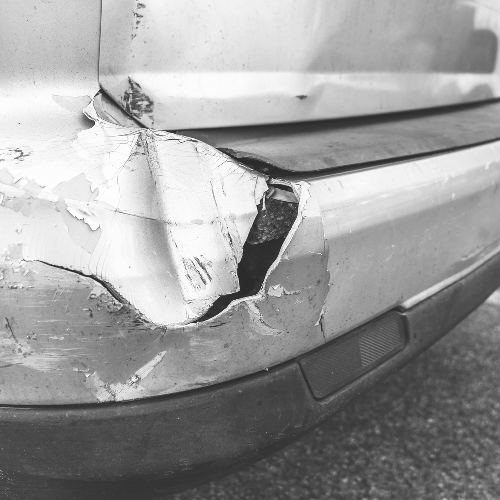

In [ ]:
from detectron2.utils.visualizer import Visualizer, ColorMode
from google.colab.patches import cv2_imshow
import random
import cv2

# Name of the validation dataset
dataset_name = "my_dataset_val"

# Load the dataset
dataset_dicts = DatasetCatalog.get(dataset_name)

# Retrieve metadata
dataset_metadata = MetadataCatalog.get(dataset_name)

# Using the predictor to make predictions
for d in random.sample(dataset_dicts, 7):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=dataset_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
from detectron2.data import build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

# Create a COCOEvaluator instance for your test dataset
evaluator = COCOEvaluator("my_dataset_val", cfg, False, output_dir="/content/drive/MyDrive/output1/evaluation")

# Build the test data loader
test_loader = build_detection_test_loader(cfg, "my_dataset_val")

# Run the model on the test data and get the evaluation metrics
inference_on_dataset(predictor.model, test_loader, evaluator)

WARNING [12/16 15:24:14 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[12/16 15:24:14 d2.data.datasets.coco]: Loaded 810 images in COCO format from /content/drive/MyDrive/CarDD_release/CarDD_COCO/annotations/instances_val2017.json
[12/16 15:24:14 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[12/16 15:24:14 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[12/16 15:24:14 d2.data.common]: Serializing 810 elements to byte tensors and concatenating them all ...
[12/16 15:24:14 d2.data.common]: Serialized dataset takes 1.80 MiB
[12/16 15:24:14 d2.evaluation.evaluator]: Start inference on 810 batches


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


[12/16 15:24:18 d2.evaluation.evaluator]: Inference done 11/810. Dataloading: 0.0017 s/iter. Inference: 0.2193 s/iter. Eval: 0.0077 s/iter. Total: 0.2287 s/iter. ETA=0:03:02
[12/16 15:24:23 d2.evaluation.evaluator]: Inference done 34/810. Dataloading: 0.0021 s/iter. Inference: 0.2200 s/iter. Eval: 0.0045 s/iter. Total: 0.2268 s/iter. ETA=0:02:55
[12/16 15:24:29 d2.evaluation.evaluator]: Inference done 55/810. Dataloading: 0.0028 s/iter. Inference: 0.2288 s/iter. Eval: 0.0037 s/iter. Total: 0.2354 s/iter. ETA=0:02:57
[12/16 15:24:34 d2.evaluation.evaluator]: Inference done 75/810. Dataloading: 0.0032 s/iter. Inference: 0.2354 s/iter. Eval: 0.0034 s/iter. Total: 0.2421 s/iter. ETA=0:02:57
[12/16 15:24:39 d2.evaluation.evaluator]: Inference done 98/810. Dataloading: 0.0029 s/iter. Inference: 0.2313 s/iter. Eval: 0.0034 s/iter. Total: 0.2378 s/iter. ETA=0:02:49
[12/16 15:24:44 d2.evaluation.evaluator]: Inference done 118/810. Dataloading: 0.0033 s/iter. Inference: 0.2328 s/iter. Eval: 0.00

OrderedDict([('bbox',
              {'AP': 22.491685931093404,
               'AP50': 41.413619926584566,
               'AP75': 19.860114639378846,
               'APs': 0.0,
               'APm': 0.45464766256845474,
               'APl': 23.165545266249296,
               'AP-dent': 2.5025832027467025,
               'AP-scratch': 4.383996424828485,
               'AP-crack': 0.0,
               'AP-glass shatter': 68.16326103445046,
               'AP-lamp broken': 20.47948259020888,
               'AP-tire flat': 39.4207923343259}),
             ('segm',
              {'AP': 33.73795551502751,
               'AP50': 42.337223217480876,
               'AP75': 37.17978954714867,
               'APs': 0.0,
               'APm': 0.26322091354065014,
               'APl': 34.891261204273164,
               'AP-dent': 3.729837512878743,
               'AP-scratch': 5.227460935663361,
               'AP-crack': 0.0,
               'AP-glass shatter': 80.5300461445593,
               'AP-